In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
eur_usd_df = pd.read_csv('^eurusd_daily_historical-data-09-30-2020.csv', index_col = [0], parse_dates = [0])
eur_usd_df = eur_usd_df.iloc[:-1,:]
eur_usd_df = eur_usd_df[::-1]
eur_usd_df

,Open,High,Low,Last,Change,Volume
Time,,,,,,
01/03/2000,1.00850,1.02800,1.00550,1.02560,0.01680,0.0
01/04/2000,1.02550,1.03400,1.02170,1.03010,0.00450,0.0
01/05/2000,1.03040,1.04000,1.02890,1.03150,0.00140,0.0
01/06/2000,1.03200,1.04130,1.02830,1.03150,0.00000,0.0
01/07/2000,1.03170,1.03330,1.02630,1.02960,-0.00190,0.0
...,...,...,...,...,...,...
09/24/2020,1.16597,1.16867,1.16265,1.16690,0.00093,247053.0
09/25/2020,1.16688,1.16847,1.16127,1.16296,-0.00394,211829.0
09/28/2020,1.16213,1.16797,1.16151,1.16650,0.00354,187734.0


In [12]:
eur_usd_df.index = pd.DatetimeIndex(data = eur_usd_df.index)
eur_usd_df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='Time', length=5384, freq=None)

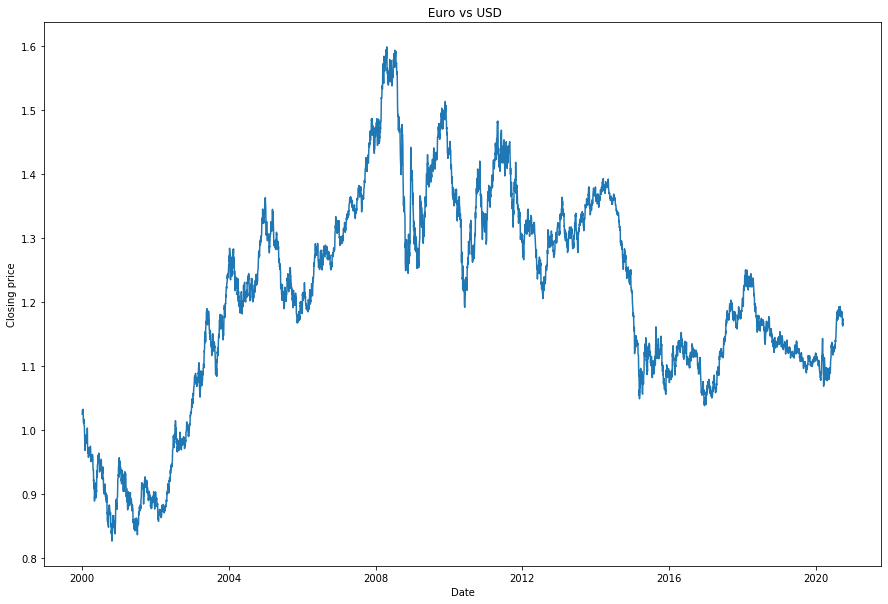

In [13]:
plt.figure(figsize = (15,10))
plt.plot(eur_usd_df['Last'])
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.title(' Euro vs USD')
plt.show()

A given time series consists of systematic components like level, trend, seasonality and non-systematic component called noise
* __Level__: The average value in series.
* __Trend__: The increasing or decreasing value in the series
* __Seasonality__: The repeating short-term cycle in the series
* __Noise__: The random variation in the series

The time series analysis works very well on stationary data, hence we need to verify if the data is stationary.

### ADF (Augmented Dickey-Fuller Test)

This is a statistical test used to determine the presence of unit root in the series, and it helps us understand if the series is stationary or not.

__Null hypothesis__: concludes the series has a unit root (value of a = 1)
__Alternate hypothesis__: conclude the series has no unit root

If we fail to reject the null hypothesis, we can say that the series is non-stationary. 
Alternatively if the rolling mean and standard mean do not change with time, it also means the data is stationary.

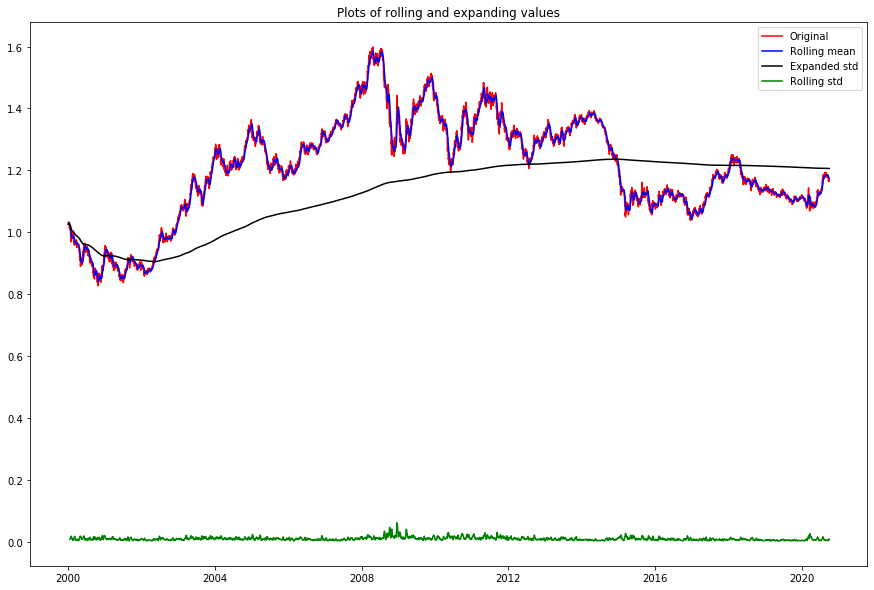

In [23]:
rolling_mean = eur_usd_df['Last'].rolling(window = 12).mean()
rolling_std = eur_usd_df['Last'].rolling(window = 12).std()
expanded_mean = eur_usd_df['Last'].expanding().mean()
plt.figure(figsize = (15,10))
plt.plot(eur_usd_df['Last'], color = 'red', label = 'Original')
plt.plot(rolling_mean, color = 'blue', label = 'Rolling mean')
plt.plot(expanded_mean, color = 'black', label = 'Expanded std')
plt.plot(rolling_std, color = 'green', label = 'Rolling std')
plt.title('Plots of rolling and expanding values')
plt.legend()
plt.show()

In [31]:
dicker_fuller_results = adfuller(x = eur_usd_df['Last'],
                                 autolag = 'AIC')
print('Test statistics: ', dicker_fuller_results[0])
print('p-value: ', dicker_fuller_results[1])
print('Number of lags used : ', dicker_fuller_results[2])
print('Number of observations used : ', dicker_fuller_results[3])
for keys, values in dicker_fuller_results[4].items():
    print('critical value ({}%):  {}'.format(keys, values))

Test statistics:  -1.8074802742310678
p-value:  0.376754320140034
Number of lags used :  0
Number of observations used :  5383
critical value (1%%):  -3.4315653856728168
critical value (5%%):  -2.8620770774534745
critical value (10%%):  -2.567055885533713


* Based on the plots the rolling mean is not constant, it is changing with time, hence based on this it is not stationary
* From dickey fuller test, the p value is 0.37, in order to reject the null hypothesis, the p value had to be lower than 0.05
* Also the test statistics is greater than the critical values, hence the data is not stationary

In order to perform time series analysis, we need to seperate seasonality and trend from the series.

<Figure size 432x288 with 0 Axes>

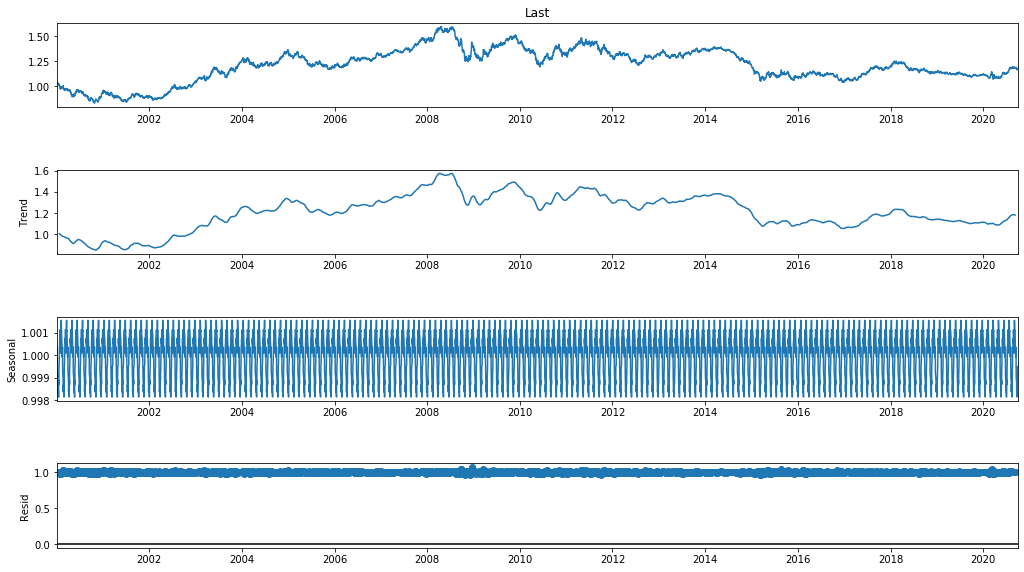

In [36]:
seasonal_result = seasonal_decompose(x = eur_usd_df['Last'],
                                     model = 'multiplicative',
                                     freq = 30)
figure = plt.figure()
figure = seasonal_result.plot()
figure.set_size_inches(16, 9)

### Make data stationary

* function to make transformations

In [46]:
def transform_data_results(data):
    rolling_mean = data.rolling(window = 12).mean()
    rolling_std = data.rolling(window = 12).std()
    expanded_mean = data.expanding().mean()
    plt.figure(figsize = (15,10))
    plt.plot(rolling_mean, color = 'blue', label = 'Rolling mean')
    plt.plot(expanded_mean, color = 'black', label = 'Expanded std')
    plt.plot(rolling_std, color = 'green', label = 'Rolling std')
    plt.title('Plots of rolling and expanding values')
    plt.legend()
    plt.show()
    
    dicker_fuller_results = adfuller(x = data,
                                     autolag = 'AIC')
    print('Dickey fuller results')
    print('Test statistics: ', dicker_fuller_results[0])
    print('p-value: ', dicker_fuller_results[1])
    print('Number of lags used : ', dicker_fuller_results[2])
    print('Number of observations used : ', dicker_fuller_results[3])
    for keys, values in dicker_fuller_results[4].items():
        print('critical value ({}%):  {}'.format(keys, values))

* TRANSFORMATION with log data

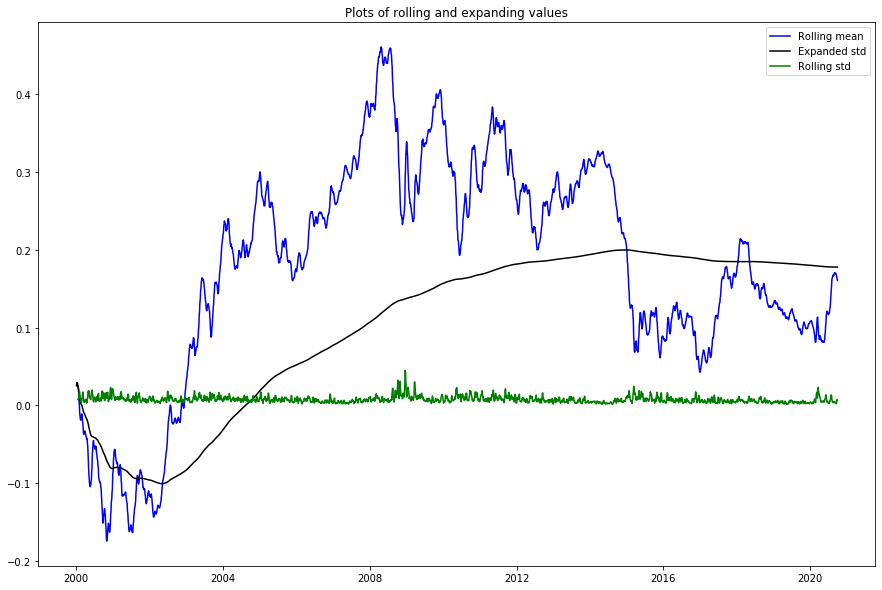

Dickey fuller results
Test statistics:  -1.7443786525990803
p-value:  0.4084043815394185
Number of lags used :  0
Number of observations used :  5383
critical value (1%%):  -3.4315653856728168
critical value (5%%):  -2.8620770774534745
critical value (10%%):  -2.567055885533713


In [47]:
log_data = np.log(eur_usd_df['Last'])
transform_data_results(log_data)

* TRANSFORMATION with 5 days Moving average of log data

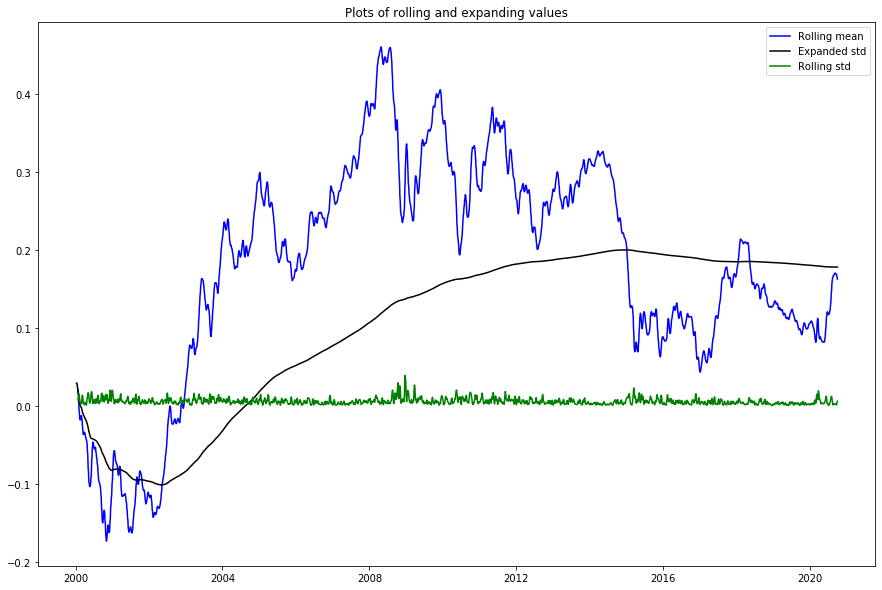

Dickey fuller results
Test statistics:  -1.8868871153592306
p-value:  0.3382547463912393
Number of lags used :  33
Number of observations used :  5345
critical value (1%%):  -3.431574030549211
critical value (5%%):  -2.862080896827635
critical value (10%%):  -2.567057918716162


In [52]:
rolling_log_data = log_data.rolling(window = 5, center = False).mean()
rolling_log_data = rolling_log_data[5:]
transform_data_results(rolling_log_data)

* TRANSFORMATION with 5 days moving average of original data

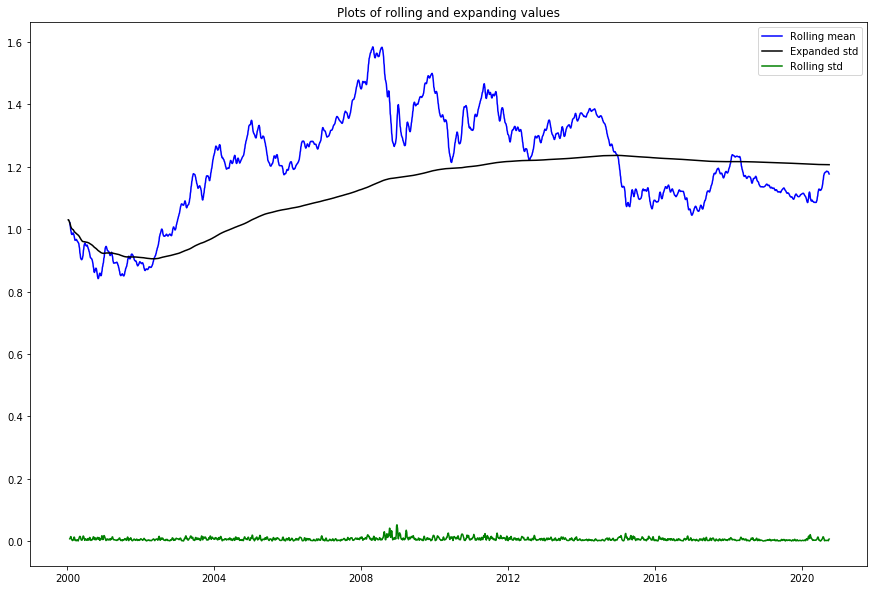

Dickey fuller results
Test statistics:  -1.9427239307978026
p-value:  0.31223687812079515
Number of lags used :  33
Number of observations used :  5345
critical value (1%%):  -3.431574030549211
critical value (5%%):  -2.862080896827635
critical value (10%%):  -2.567057918716162


In [53]:
moving_average_original = eur_usd_df['Last'].rolling(window = 5, center = False).mean()
moving_average_original = moving_average_original[5:]
transform_data_results(moving_average_original)

* TRANSFORMATION with difference between log data and first order difference of log data
* difference = log_data - log_data.shift()

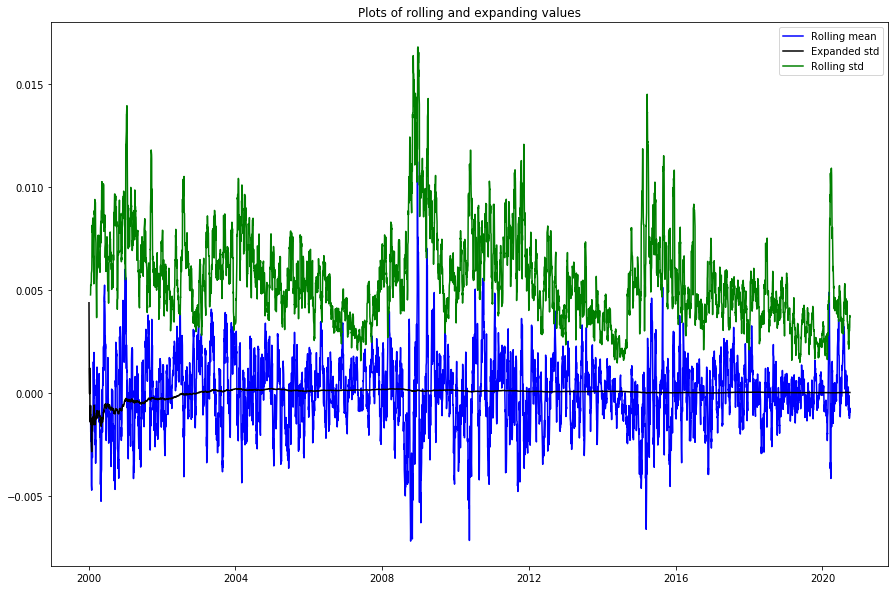

Dickey fuller results
Test statistics:  -73.9101291536764
p-value:  0.0
Number of lags used :  0
Number of observations used :  5382
critical value (1%%):  -3.4315656116048294
critical value (5%%):  -2.8620771772721496
critical value (10%%):  -2.5670559386705563


In [55]:
difference_log_data = log_data.diff(periods = 1)
difference_log_data = difference_log_data[1:]
transform_data_results(difference_log_data)